<a href="https://colab.research.google.com/github/Joselyne50/DEEPLEARNING/blob/main/Jossy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from typing import List, Tuple
import copy
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

In [ ]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

The following class defines the grid world environment. The grid world looks like:

```
____________________________________________________________
|___|_0_|_1_|_2_|_3_|_4_|_5_|_6_|_7_|_8_|_9_|_10|_11|_12|_13|
|_0_|___|___|___|___|___|___|_x_|_x_|___|___|___|___|___|___|
|_1_|___|___|___|___|___|___|_x_|_x_|___|___|___|___|___|___|
|_2_|___|___|___|_x_|___|___|_x_|_x_|___|___|___|___|_x_|___|
|_3_|___|___|___|_x_|___|___|_x_|___|___|___|___|_x_|_x_|___|
|_4_|___|_B_|___|_x_|___|___|___|___|___|___|___|_x_|_x_|_G_|
|_5_|_A_|___|___|_x_|___|___|___|___|___|___|___|_x_|_x_|___|
```



In [ ]:
AGENT = 'A'
BOX = 'B'
GOAL = 'G'
DANGER = 'x'
GRID = '_'


class CliffBoxGridWorld:
    """
    Cliff Box Pushing Grid World.
    """
    action_space = [1, 2, 3, 4]
    forces = {
        1: np.array([-1, 0]),
        2: np.array([1,  0]),
        3: np.array([0, -1]),
        4: np.array([0,  1]),
    }
    world_width = 14
    world_height = 6
    goal_pos = np.array([4, 13])
    init_agent_pos = np.array([5, 0])
    init_box_pos = np.array([4, 1])
    danger_region = [
        [(2, 3), (5, 3)],
        [(0, 6), (3, 6)],
        [(0, 7), (2, 7)],
        [(3, 11), (5, 11)],
        [(2, 12), (5, 12)],
    ]

    def __init__(self,
                 episode_length=100,
                 render=False,
                 ):
        """
        The grid world looks like:
        ____________________________________________________________
        |___|_0_|_1_|_2_|_3_|_4_|_5_|_6_|_7_|_8_|_9_|_10|_11|_12|_13|
        |_0_|___|___|___|___|___|___|_x_|_x_|___|___|___|___|___|___|
        |_1_|___|___|___|___|___|___|_x_|_x_|___|___|___|___|___|___|
        |_2_|___|___|___|_x_|___|___|_x_|_x_|___|___|___|___|_x_|___|
        |_3_|___|___|___|_x_|___|___|_x_|___|___|___|___|_x_|_x_|___|
        |_4_|___|_B_|___|_x_|___|___|___|___|___|___|___|_x_|_x_|_G_|
        |_5_|_A_|___|___|_x_|___|___|___|___|___|___|___|_x_|_x_|___|
        """
        # Environment configurations.
        self.episode_length = episode_length
        self.render = render
        self.agent_pos = self.init_agent_pos
        self.box_pos = self.init_box_pos

        # Visualization.
        if self.render:
            self.world = np.chararray((self.world_height, self.world_width))
            self.last_agent_pos = copy.deepcopy(self.agent_pos)
            self.last_box_pos = copy.deepcopy(self.box_pos)
            self.world[:] = GRID
            for region in self.danger_region:
                A, B = region
                assert A[1] == B[1], "A[1] != B[1]"
                self.world[A[0]:B[0]+1, A[1]] = DANGER
            self.world[self.agent_pos[0], self.agent_pos[1]] = AGENT
            self.world[self.box_pos[0], self.box_pos[1]] = BOX
            self.world[self.goal_pos[0], self.goal_pos[1]] = GOAL

    def reset(self):
        """
        Resets the environment.

        Returns:
            The initial state (agent position and box position).
        """
        self.timesteps = 0
        self.action_history = []
        self.agent_pos = self.init_agent_pos
        self.box_pos = self.init_box_pos

        return tuple([*self.agent_pos.tolist(), *self.box_pos.tolist()])

    def step(self, actions: int):
        """
        Args: actions (a list of int).

        Returns:
            The next state, reward, done, info.
        """
        self.action_history.append(actions)

        # Update the state.
        force = self.forces[actions]
        # check if the agent is near the box
        if np.sum(np.abs(self.agent_pos - self.box_pos)) == 1:
            # check if box is moved
            if all(self.agent_pos + force == self.box_pos):
                # check out of boundary
                self.box_pos = self._check_pos_boundary(pos=self.box_pos + force, box_hard_boundary=True)
        # move the agent
        new_agent_pos = self._check_pos_boundary(self.agent_pos + force)
        if not all(new_agent_pos == self.box_pos):
            self.agent_pos = new_agent_pos
        state = tuple([*self.agent_pos.tolist(), *self.box_pos.tolist()])

        # Calculate the rewards
        done = self.timesteps == self.episode_length - 1
        # the distance between agents and box
        dist = np.sum(np.abs(self.agent_pos - self.box_pos))
        reward = -1  # -1 for each step
        reward -= dist
        # if agents or box is off the cliff
        if self._check_off_cliff(self.agent_pos) or self._check_off_cliff(self.box_pos):
            reward += -1000
            done = True

        if all(self.box_pos == self.goal_pos):
            reward += 1000
            done = True

        reward -= np.sum(np.abs(self.box_pos - self.goal_pos))

        if self.render:
            self._update_render()

        self.timesteps += 1
        info = {}

        return state, reward, done, info

    def print_world(self):
        """
        Render the world in the command line.
        """
        if len(self.action_history) > 0:
            print(f'Action: {self.action_history[-1]}')
        print(self.world)

    def _check_pos_boundary(self, pos, box_hard_boundary: bool = False):
        """
        Move the given position within the world bound.
        """
        if pos[0] < 0:
            pos[0] = 0
        if pos[0] >= self.world_height:
            pos[0] = self.world_height - 1
        if pos[1] < 0:
            pos[1] = 0
        if pos[1] >= self.world_width:
            pos[1] = self.world_width - 1

        if box_hard_boundary:
            if pos[0] == 0:
                pos[0] += 1
            elif pos[0] == self.world_height - 1:
                pos[0] = self.world_height - 2
            if pos[1] == 0:
                pos[1] += 1

        return pos

    def _check_off_cliff(self, pos):
        """
        Check if the given position is off cliff.
        """
        for region in self.danger_region:
            A, B = region
            assert A[1] == B[1], "A[1] != B[1]"
            if A[0] <= pos[0] <= B[0] and pos[1] == A[1]:
                return True
        return False

    def _update_render(self):
        """
        Update the render information.
        """
        if not all(self.last_agent_pos == self.agent_pos):
                pos = self.last_agent_pos
                if (pos[0] != self.goal_pos[0]) or (pos[1] != self.goal_pos[1]):
                    self.world[pos[0], pos[1]] = GRID

        if not all(self.last_box_pos == self.box_pos):
            pos = self.last_box_pos
            if self.world[pos[0], pos[1]].decode('UTF-8') not in {AGENT}:
                self.world[pos[0], pos[1]] = GRID

        if (self.agent_pos[0] != self.goal_pos[0]) or (self.agent_pos[1] != self.goal_pos[1]):
            self.world[self.agent_pos[0], self.agent_pos[1]] = AGENT
        self.world[self.box_pos[0], self.box_pos[1]] = BOX
        self.last_box_pos = copy.deepcopy(self.box_pos)
        self.last_agent_pos = copy.deepcopy(self.agent_pos)

You need to complete the learn() method of the following class to implement your RL algorithm.


In [ ]:
class RLAgent:
    def __init__(self, env, num_episodes, epsilon=0.1, alpha=0.1, gamma=0.99):
        self.action_space = env.action_space

        self.q_table = {}
        self.env = env
        self.num_episodes = num_episodes
        self.epsilon = epsilon
        self.alpha = alpha
        self.gamma = gamma


    def act(self, state):
        """Epsilon-greedy action selection."""
        epsilon = 0.1
        if np.random.uniform(0, 1) < epsilon:
            return np.random.choice(self.action_space)
        q_values = {action: self.q_table.setdefault(state, {}).setdefault(action, 0) for action in self.action_space}
        original_fake = pd.DataFrame(self.q_table)
        return max(q_values, key=q_values.get)

    # UPDATING Q-VALUES
    def Update(self, state, action, reward, next_state):
        max_next_q_value = max([self.q_table.setdefault(state, {}).setdefault(action, 0) for a in self.action_space])
        current_q_value = self.q_table.setdefault(state, {}).setdefault(action, 0)
        self.q_table[state][action] = current_q_value + self.alpha * (reward + self.gamma * max_next_q_value - current_q_value)

    def learn(self):
        rewards = []

        for _ in range(self.num_episodes):
            cumulative_reward = 0
            state = self.env.reset()
            done = False
            while not done:
                action = self.act(state)
                next_state, reward, done, _ = self.env.step(action)

                self.Update(state, action, reward, next_state)
                state = next_state
                cumulative_reward += reward
            rewards.append(cumulative_reward)

        return rewards

    def display_v_table(self):
        return {state: max(actions.values()) for state, actions in self.q_table.items()}

    def display_policy(self):
        return {state: max(actions, key=actions.get) for state, actions in self.q_table.items()}

    # def visualize_v_table(self):
    #     v_table = self.display_v_table()
    #     shape = (self.env.world_height, self.env.world_width)

    #     v_matrix = np.full(shape, -1000)
    #     for state, value in v_table.items():
    #         agent_row, agent_col = state[:2]
    #         v_matrix[agent_row, agent_col] = max(v_matrix[agent_row, agent_col], value)
    #     row_v = []
    #     for i in range(shape[0]):
    #         row_v = [f"{v_matrix[i, j]:.2f}" if v_matrix[i, j] != -1000 else "0.00" for j in range(shape[1])]
    #     pd.DataFrame(row_v)
    # print(' | '.join(row_v))


Here is the game interface where you can manually move the agent.

In [ ]:
env = CliffBoxGridWorld(render=True)
env.reset()
env.print_world()
done = False
rewards = []

while not done:
  try:
    action = int(input("Please input the actions \nup: 1, \ndown: 2, \nleft: 3, \nright: 4 \nExit Game: 0 \n: "))
    if not action:
      break
    state, reward, done, info = env.step(action)
    rewards.append(reward)
    print(f'step: {env.timesteps}, state: {state}, actions: {action}, reward: {reward}')
    env.print_world()
  except Exception:
    print()
    print('Invalid action', '\n', '_'*100)

print(f'rewards: {sum(rewards)}')
print(f'action history: {env.action_history}')

[[b'_' b'_' b'_' b'_' b'_' b'_' b'x' b'x' b'_' b'_' b'_' b'_' b'_' b'_']
 [b'_' b'_' b'_' b'_' b'_' b'_' b'x' b'x' b'_' b'_' b'_' b'_' b'_' b'_']
 [b'_' b'_' b'_' b'x' b'_' b'_' b'x' b'x' b'_' b'_' b'_' b'_' b'x' b'_']
 [b'_' b'_' b'_' b'x' b'_' b'_' b'x' b'_' b'_' b'_' b'_' b'x' b'x' b'_']
 [b'_' b'B' b'_' b'x' b'_' b'_' b'_' b'_' b'_' b'_' b'_' b'x' b'x' b'G']
 [b'A' b'_' b'_' b'x' b'_' b'_' b'_' b'_' b'_' b'_' b'_' b'x' b'x' b'_']]
Please input the actions 
up: 1, 
down: 2, 
left: 3, 
right: 4 
Exit Game: 0 
: 1
step: 1, state: (4, 0, 4, 1), actions: 1, reward: -14
Action: 1
[[b'_' b'_' b'_' b'_' b'_' b'_' b'x' b'x' b'_' b'_' b'_' b'_' b'_' b'_']
 [b'_' b'_' b'_' b'_' b'_' b'_' b'x' b'x' b'_' b'_' b'_' b'_' b'_' b'_']
 [b'_' b'_' b'_' b'x' b'_' b'_' b'x' b'x' b'_' b'_' b'_' b'_' b'x' b'_']
 [b'_' b'_' b'_' b'x' b'_' b'_' b'x' b'_' b'_' b'_' b'_' b'x' b'x' b'_']
 [b'A' b'B' b'_' b'x' b'_' b'_' b'_' b'_' b'_' b'_' b'_' b'x' b'x' b'G']
 [b'_' b'_' b'_' b'x' b'_' b'_' b'_' b'_' b'_' b'_

Training The Agent

In [ ]:
env = CliffBoxGridWorld()
agent = RLAgent(env, num_episodes=1000)
rewards = agent.learn()
shape = (CliffBoxGridWorld.world_height, CliffBoxGridWorld.world_width)  # Define the shape of your environment grid
agent.visualize_v_table()

AttributeError: ignored

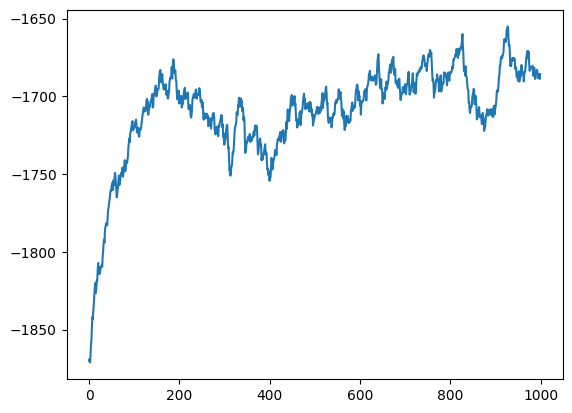

In [ ]:
# Smooth plot
weight=0.99
last = rewards[0]
smoothed = []
for v in rewards:
    smoothed_val = last * weight + (1 - weight) * v
    smoothed.append(smoothed_val)
    last = smoothed_val

# Plot the learning curve
plt.plot(smoothed)

You need to complete the following method to visualize your training results.

In [ ]:
def visualize_v_table():
    """Use Grid form to Visualize V-table."""
    v_table = agent.display_v_table()
    h, w = (env.world_height, env.world_width)
    v_dataframe = np.full((h, w, h, w), -1000)
    for s, v in v_table.items():
        a_x, a_y, box_x, box_y = s
        v_dataframe[a_x, a_y, box_x, box_y] = max(v_dataframe[a_x, a_y, box_x, box_y], v)


    for x in range(h):
        for y in range(shape[1]):
            print(f"Agent at ({x}, {y})")
            # row_v = []
            for box in range(h):
                row_values = [f"{v_dataframe[x, y, box, boy]:.2f}" if v_dataframe[x, y, box, boy] != -1000 else "0.00" for boy in range(shape[1])]
                # row_v.append(row_values)
                print(' | '.join(row_values))
            # d = pd.DataFrame(row_v)
            # d.head(10)

visualize_v_table()

Agent at (0, 0)
0.00 | 0.00 | 0.00 | 0.00 | 0.00 | 0.00 | 0.00 | 0.00 | 0.00 | 0.00 | 0.00 | 0.00 | 0.00 | 0.00
0.00 | -37.00 | -39.00 | -10.00 | -1.00 | -1.00 | 0.00 | 0.00 | 0.00 | 0.00 | 0.00 | 0.00 | 0.00 | 0.00
0.00 | -41.00 | -50.00 | 0.00 | 0.00 | 0.00 | 0.00 | 0.00 | 0.00 | 0.00 | 0.00 | 0.00 | 0.00 | 0.00
0.00 | -63.00 | -66.00 | 0.00 | 0.00 | 0.00 | 0.00 | 0.00 | 0.00 | 0.00 | 0.00 | 0.00 | 0.00 | 0.00
0.00 | -260.00 | -246.00 | 0.00 | 0.00 | 0.00 | 0.00 | 0.00 | 0.00 | 0.00 | 0.00 | 0.00 | 0.00 | 0.00
0.00 | 0.00 | 0.00 | 0.00 | 0.00 | 0.00 | 0.00 | 0.00 | 0.00 | 0.00 | 0.00 | 0.00 | 0.00 | 0.00
Agent at (0, 1)
0.00 | 0.00 | 0.00 | 0.00 | 0.00 | 0.00 | 0.00 | 0.00 | 0.00 | 0.00 | 0.00 | 0.00 | 0.00 | 0.00
0.00 | -28.00 | -36.00 | -13.00 | -3.00 | -1.00 | 0.00 | 0.00 | 0.00 | 0.00 | 0.00 | 0.00 | 0.00 | 0.00
0.00 | -41.00 | -47.00 | 0.00 | 0.00 | 0.00 | 0.00 | 0.00 | 0.00 | 0.00 | 0.00 | 0.00 | 0.00 | 0.00
0.00 | -64.00 | -63.00 | 0.00 | 0.00 | 0.00 | 0.00 | 0.00 | 0.00 | 0.0

In [ ]:
#Ploting Learning progress
plt.plot(range(len(rewards)), rewards)
plt.xlabel('Episode')
plt.ylabel('Episode Rewards')
plt.title('Learning Progress: Episode Rewards vs. Episodes')
plt.grid(True)
plt.show()

In [ ]:
policy = agent.display_policy()
print("Policy:")
for state, action in policy.items():
    print(f"State: {state}, The best action: {action}")